In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import seaborn as sns

In [2]:
plt.set_cmap('coolwarm')

<Figure size 432x288 with 0 Axes>

In [3]:
np.set_printoptions(threshold=10)
sigmoid = lambda x : 1 / (1 + np.exp(-x))

# Binary Classification

### Generating Bivariate Classification Data

In [4]:
def generate_classification_data(size, classes=2, angle=None, sep=1, noise=1, n_features=2):
    means = np.linspace(-sep, sep, classes) * classes
    X = np.concatenate([np.random.normal(loc=means[i], 
                                         scale=noise, 
                                         size=(size // classes, n_features)) for i in range(classes)], axis=0)
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    angle = angle if angle else np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X, y

In [5]:
X, y = generate_classification_data(500, noise=1.75)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


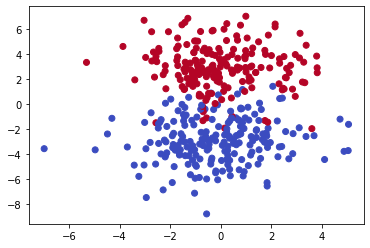

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Logistic Regression  Model for Binary Classification

In [25]:
class BinaryClassifier:
    def __init__(self, n_features, degree=1, weights=None, normalize=True, threshold=0.5):
        self.__n_features = n_features
        self.__degree = degree
        self.weights = weights if np.sum(weights) else np.random.randn(n_features * degree + 1) 
        self.__normalize = normalize
        self.__scaling_params = (0, 1)
        self.__threshold = threshold
        self.metrics = None
            
    def __transform(self, X, training=False, normalize=True):
        X_init = X
        for i in range(2, self.__degree + 1):
            X = np.c_[X, X_init ** i]
        if training:
            self.__scaling_params = (X.mean(axis=0), X.std(axis=0))
        if self.__normalize:
            mu, s = self.__scaling_params
            X = (X - mu) / (s + 1e-9)
        return np.c_[np.ones((X.shape[0], 1)), X].T  
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        X = self.__transform(X, training=True)
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            y_pred = sigmoid(self.weights.T @ X)
            J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
            acc = np.mean((y_pred >= self.__threshold) == y)
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)
            self.weights -= alpha * np.mean((y_pred - y) * X, axis=1)            
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics= {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        
    def predict(self, X, predict_classes=False):
        y_pred = sigmoid(self.weights.T @ self.__transform(X))
        if predict_classes:
            y_pred = y_pred >= self.__threshold
        return y_pred
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        acc = np.mean((y_pred >= self.__threshold) == y)
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, y_pred >= self.__threshold).ravel()
        recl = tp / (tp + fn)
        prec = tp / (tp + fp)
        evaluation = {'loss' : J, 'accurracy' : acc, 'precision' : prec, 'recall' : recl}
        return evaluation
    
    def get_weights(self, return_scaling_params=False):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[1:], 'bias' : self.weights[0]}
        if return_scaling_params:
            model_weights['scaling_mean'], model_weights['scaling_std'] = self.__scaling_params
        return model_weights 
    
    def plot_decision_boundary(self, X, y, figsize=(7,7), ec='white', s=50,alpha=0.8):
        plt.figure(figsize=figsize)
        x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
        x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

        X1, X2 = np.meshgrid(x1, x2)
        X1, X2 = X1.ravel(), X2.ravel() 
        preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

        extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
        plt.imshow(preds, origin='lower', extent=extent, alpha=alpha, aspect='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, ec=ec, s=s)

### Training

In [26]:
model = BinaryClassifier(n_features=2)

In [27]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 1.501570	 acc = 0.1075
Epoch 2/10
400/400 [==============] : loss = 1.051444	 acc = 0.155
Epoch 3/10
400/400 [==============] : loss = 0.742428	 acc = 0.44
Epoch 4/10
400/400 [==============] : loss = 0.559539	 acc = 0.86
Epoch 5/10
400/400 [==============] : loss = 0.454943	 acc = 0.935
Epoch 6/10
400/400 [==============] : loss = 0.390958	 acc = 0.94
Epoch 7/10
400/400 [==============] : loss = 0.348406	 acc = 0.945
Epoch 8/10
400/400 [==============] : loss = 0.318130	 acc = 0.945
Epoch 9/10
400/400 [==============] : loss = 0.295467	 acc = 0.9475
Epoch 10/10
400/400 [==============] : loss = 0.277841	 acc = 0.945


Text(0.5, 1.0, 'Training Accuracy')

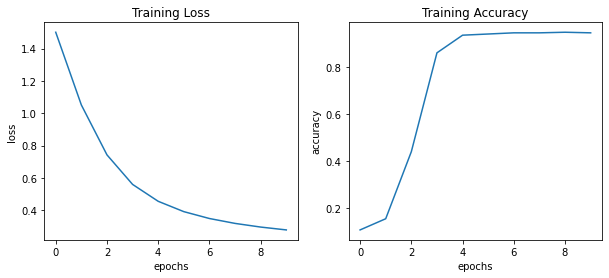

In [28]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [29]:
min(model.metrics['loss_per_epochs'])

0.27784070630784213

In [30]:
model.get_weights()

{'weights': array([-0.00663609,  1.77855164]), 'bias': -0.05363053120371544}

### Evaluation

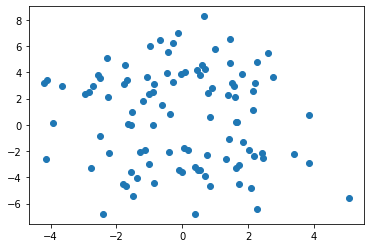

In [31]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [32]:
model.evaluate(X_test, y_test)

{'loss': 0.23137704546082155,
 'accurracy': 0.97,
 'precision': 0.9649122807017544,
 'recall': 0.9821428571428571}

In [33]:
y_pred = model.predict(X_test, predict_classes=True)

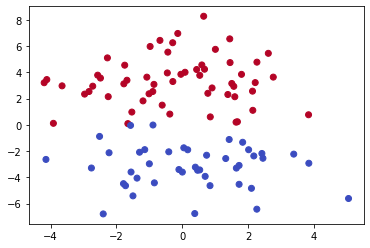

In [34]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

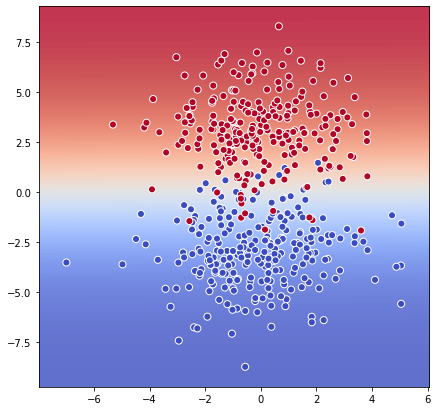

In [35]:
model.plot_decision_boundary(X, y)

---

### Generating Circular Classification Data

In [36]:
def generate_circular_data(size, classes=2, sep=5, noise=1.5, n_features=2, centre=0):
    x1 = np.linspace(-sep, sep, size // (2 * classes))
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // (2 * classes)) * (noise * sep / 10)
    X = np.r_[np.c_[x1, x2], np.c_[x1, -x2]]
    X = np.r_[X, np.random.normal(loc=centre, scale=noise, size=(size // classes, n_features))]                 
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    return X, y

In [37]:
X, y = generate_circular_data(500)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


(-5.5, 5.5, -7.28678530516556, 7.28678530516556)

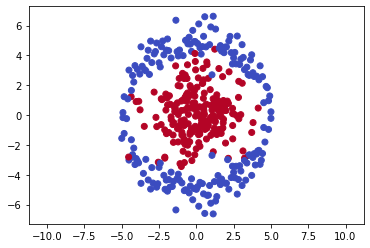

In [40]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.axis('equal')

### Training

In [41]:
model = BinaryClassifier(n_features=2, degree=2)

In [42]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 1.270608	 acc = 0.37
Epoch 2/10
400/400 [==============] : loss = 0.942475	 acc = 0.4275
Epoch 3/10
400/400 [==============] : loss = 0.702029	 acc = 0.54
Epoch 4/10
400/400 [==============] : loss = 0.539523	 acc = 0.7275
Epoch 5/10
400/400 [==============] : loss = 0.434489	 acc = 0.8525
Epoch 6/10
400/400 [==============] : loss = 0.366739	 acc = 0.905
Epoch 7/10
400/400 [==============] : loss = 0.321560	 acc = 0.95
Epoch 8/10
400/400 [==============] : loss = 0.289897	 acc = 0.9575
Epoch 9/10
400/400 [==============] : loss = 0.266587	 acc = 0.96
Epoch 10/10
400/400 [==============] : loss = 0.248690	 acc = 0.96


Text(0.5, 1.0, 'Training Accuracy')

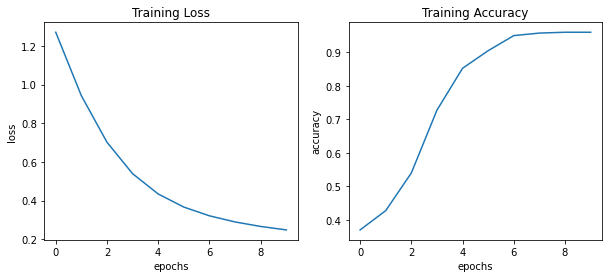

In [43]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [44]:
min(model.metrics['loss_per_epochs'])

0.24868974102912975

In [45]:
model.get_weights()

{'weights': array([ 0.08759962,  0.10398878, -0.98068815, -1.70797649]),
 'bias': -0.07167581326509974}

### Evaluation

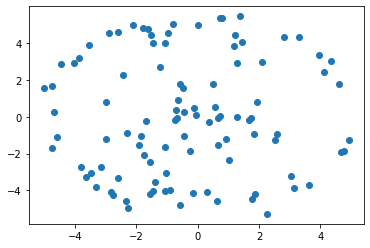

In [46]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [47]:
model.evaluate(X_test, y_test)

{'loss': 0.260702175673628,
 'accurracy': 0.93,
 'precision': 0.975,
 'recall': 0.8666666666666667}

In [48]:
y_pred = model.predict(X_test, predict_classes=True)

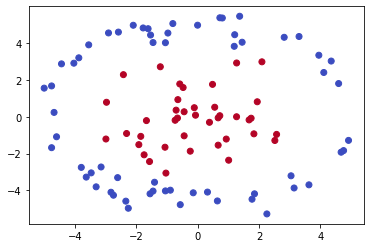

In [49]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

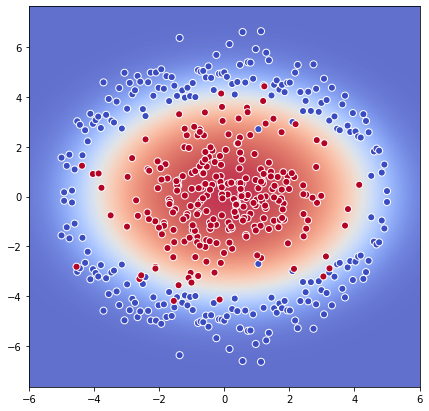

In [50]:
model.plot_decision_boundary(X, y)

---

### Generating Spiral Classification Data

In [51]:
def generate_spiral_data(n, sep=2, noise=2, centre=(0, 0)):
    size = int(n / 1.5)
    x1 = np.linspace(-sep, sep, size // 2)
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // 2) * (noise * sep / 10)
    X1 = np.r_[np.c_[x1 + centre[0], x2 + centre[1]], 
               np.c_[x1[:size // 4] + centre[0], -x2[:size // 4] + centre[1]]]
    X2 = np.r_[np.c_[x1[size // 4:] + centre[0] + sep / 2, x2[size // 4:] + centre[1] + sep / 2], 
               np.c_[x1 + centre[0] + sep / 2, -x2 + centre[1] + sep / 2]]
    X = np.r_[X1, X2]
    left = n - X.shape[0]
    if left > 0:
        X = np.r_[X, np.random.randn(left, 2) + centre]
    angle = np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    y = np.r_[np.zeros(n // 2), np.ones(n // 2)]
    return X, y

In [52]:
X, y = generate_spiral_data(500)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


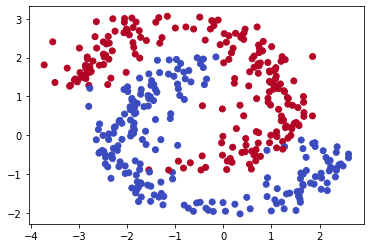

In [55]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Training

In [56]:
model = BinaryClassifier(n_features=2, degree=3)

In [57]:
model.fit(X_train, y_train, epochs=100, alpha=1)

Epoch 1/100
400/400 [==============] : loss = 1.350046	 acc = 0.335
Epoch 2/100
400/400 [==============] : loss = 0.945506	 acc = 0.3875
Epoch 3/100
400/400 [==============] : loss = 0.726037	 acc = 0.535
Epoch 4/100
400/400 [==============] : loss = 0.607767	 acc = 0.6375
Epoch 5/100
400/400 [==============] : loss = 0.538860	 acc = 0.69
Epoch 6/100
400/400 [==============] : loss = 0.496744	 acc = 0.73
Epoch 7/100
400/400 [==============] : loss = 0.469511	 acc = 0.7525
Epoch 8/100
400/400 [==============] : loss = 0.450758	 acc = 0.7675
Epoch 9/100
400/400 [==============] : loss = 0.437018	 acc = 0.7725
Epoch 10/100
400/400 [==============] : loss = 0.426379	 acc = 0.7875
Epoch 11/100
400/400 [==============] : loss = 0.417758	 acc = 0.7925
Epoch 12/100
400/400 [==============] : loss = 0.410524	 acc = 0.8125
Epoch 13/100
400/400 [==============] : loss = 0.404286	 acc = 0.8175
Epoch 14/100
400/400 [==============] : loss = 0.398798	 acc = 0.825
Epoch 15/100
400/400 [==============

Text(0.5, 1.0, 'Training Accuracy')

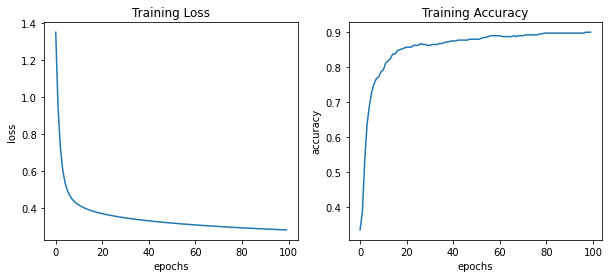

In [58]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [59]:
min(model.metrics['loss_per_epochs'])

0.2841660137930718

In [60]:
model.get_weights()

{'weights': array([ 2.79509547,  1.21175531, -1.04250273, -0.4266973 , -3.09064508,
         1.29774038]),
 'bias': 0.03773184626282658}

### Evaluation

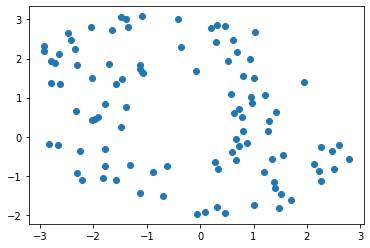

In [61]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [62]:
model.evaluate(X_test, y_test)

{'loss': 0.30965362375120004,
 'accurracy': 0.86,
 'precision': 0.8333333333333334,
 'recall': 0.9}

In [63]:
y_pred = model.predict(X_test, predict_classes=True)

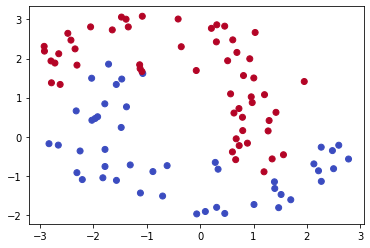

In [64]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

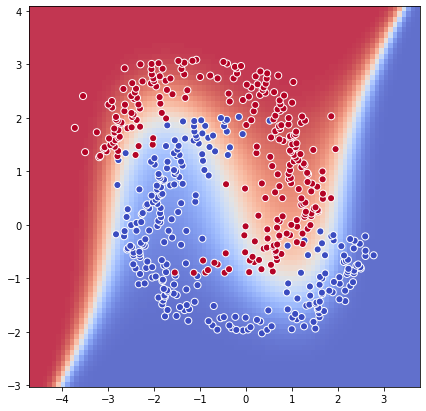

In [65]:
model.plot_decision_boundary(X, y)